# LioNets: Turbofan Engine Degradation Simulation Dataset with Neural Networks

In this notebook, we present how LioNets can be applied in predictive models using time series data.

In [1]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
%matplotlib inline
from IPython.display import Image
from IPython.display import SVG
from IPython.display import display                               
from ipywidgets import interactive
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pd
import seaborn as sns
import numpy as np
import random
import re
from math import sqrt, exp, log
import math
from sklearn.linear_model import Lasso, Ridge, RidgeCV, SGDRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, balanced_accuracy_score, accuracy_score
import keras
import keras.backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, TimeDistributed, RepeatVector,Flatten, Input, Dropout, SimpleRNN, LSTM, concatenate, Reshape, Conv1D, GlobalMaxPool1D
from keras.utils import plot_model
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)


from lionets import LioNets
from altruist.altruist import Altruist
from utilities.evaluation import Evaluation
from utilities.load_dataset import Load_Dataset

from lime.lime_text import LimeTextExplainer
from lime.lime_tabular import LimeTabularExplainer
from innvestigate.utils.keras import checks
import innvestigate
import innvestigate.utils as iutils

Using TensorFlow backend.


First of all, we load and clean our data.

In [3]:
fm, feature_names = Load_Dataset.load_data_turbofan(False)

fm1_train = fm['FaultMode1']['df_train']
fm1_train_target = fm1_train['RUL'].values
fm1_test= fm['FaultMode1']['df_test']
fm1_test_target = fm1_test['RUL'].values

We are dropping some unecessary features.

In [4]:
LSTM_train = fm1_train.drop(columns=['t', 'os_1', 'os_2', 'os_3', 's_01', 's_05', 's_06', 's_10', 's_16', 's_18', 's_19', 's_22', 's_23', 's_24', 's_25', 's_26'])
LSTM_test = fm1_test.drop(columns=['t', 'os_1', 'os_2', 'os_3', 's_01', 's_05', 's_06', 's_10', 's_16', 's_18', 's_19', 's_22', 's_23', 's_24', 's_25', 's_26'])

We collect the different units, in order to the next steps to create time windows

In [5]:
train_units = set(LSTM_train['u'].values)
test_units = set(LSTM_test['u'].values)

We are scaling our data per feature

In [6]:
sensors = ['s_02', 's_03', 's_04', 's_07', 's_08', 's_09', 's_11', 's_12',
            's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
scalers = {}
for column in sensors:
    scaler = MinMaxScaler(feature_range=(0,1))
    LSTM_train[column] = scaler.fit_transform(LSTM_train[column].values.reshape(-1,1))
    LSTM_test[column] = scaler.transform(LSTM_test[column].values.reshape(-1,1))
    scalers[column] = scaler

We create time windows with a specific size. In this example, we create time windows of 50 timesteps.

In [7]:
unit_scalers = {}
window = 50
temp_LSTM_x_train = []
LSTM_y_train = []
for unit in train_units:
    temp_unit = LSTM_train[LSTM_train['u']==unit].drop(columns=['u','RUL']).values
    temp_unit_RUL = LSTM_train[LSTM_train['u']==unit]['RUL'].values
    
    for i in range(len(temp_unit) - window + 1):#elekse edw an len temp_unit - window > 0
        temp_instance = []
        for j in range(window):
            temp_instance.append(temp_unit[i+j])
        temp_LSTM_x_train.append(np.array(temp_instance))
        LSTM_y_train.append(temp_unit_RUL[i+window-1])
LSTM_y_train = np.array(LSTM_y_train)
LSTM_x_train = np.array(temp_LSTM_x_train)

temp_LSTM_x_test = []
LSTM_y_test = []
for unit in test_units:
    temp_unit = LSTM_test[LSTM_test['u']==unit].drop(columns=['u','RUL']).values
    temp_unit_RUL = LSTM_test[LSTM_test['u']==unit]['RUL'].values
        
    for i in range(len(temp_unit) - window + 1):#elekse edw an len temp_unit - window > 0
        temp_instance = []
        for j in range(window):
            temp_instance.append(temp_unit[i+j])
        temp_LSTM_x_test.append(np.array(temp_instance))
        LSTM_y_test.append(temp_unit_RUL[i+window-1])
LSTM_y_test = np.array(LSTM_y_test)
LSTM_x_test = np.array(temp_LSTM_x_test)

We can check how many train, test instances we have. These are changing regarding the time window size.

In [8]:
LSTM_x_train.shape, LSTM_x_test.shape, LSTM_y_train.shape, LSTM_y_test.shape

((15731, 50, 14), (8255, 50, 14), (15731,), (8255,))

Moreover, we scale our target data, in order to train our models faster

In [9]:
temp_LSTM_y_train = [[i] for i in LSTM_y_train]
temp_LSTM_y_test = [[i] for i in LSTM_y_test]
target_scaler = MinMaxScaler()
target_scaler.fit(temp_LSTM_y_train)
temp_LSTM_y_train = target_scaler.transform(temp_LSTM_y_train)
temp_LSTM_y_test = target_scaler.transform(temp_LSTM_y_test)

We need a rmse loss function too!

In [10]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

Then, we train the predictor.

In [11]:
feature_names = fm1_train.columns
encoder_input = Input(shape=(LSTM_x_train[0].shape))
encoded_input = Reshape((14,50))(encoder_input)
encoded_r = []
for i in range(14):
    temp_encoded = LSTM(units=51, dropout=0.5, return_sequences=True, activation='tanh')(encoded_input)
    temp_encoded = Dropout(0.7)(temp_encoded)
    temp_encoded = LSTM(units=50, dropout=0.5, return_sequences=False, activation='tanh')(temp_encoded)
    encoded_r.append(temp_encoded)
encoded = concatenate(encoded_r)
encoded = Dropout(0.7)(encoded)
encoded = Dense(500, activation='tanh')(encoded)#Relu and selu
encoded = Dropout(0.7)(encoded)
predictions = Dense(1, activation='sigmoid')(encoded)#Relu and selu
predictor = Model(encoder_input,predictions)

predictor.compile(optimizer="adam",loss=[root_mean_squared_error],metrics=['mae','mse'])
#print(predictor.summary())

checkpoint_name = 'TEDS_Predictor_RUL.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 2, save_best_only = True, mode ='auto')

In [12]:
#predictor.fit(LSTM_x_train, temp_LSTM_y_train, epochs=500, batch_size=256, shuffle=True, 
#              validation_split=0.33, verbose=2, callbacks=[checkpoint])

We load our weights, and we measure the performance.

In [13]:
weights_file = 'weights/TEDS_Predictor_RUL.hdf5' # choose the best checkpoint few features
predictor.load_weights(weights_file) # load it
predictor.compile(optimizer="adam",loss=[root_mean_squared_error],metrics=['mae','mse'])

In [14]:
temp_pred = target_scaler.inverse_transform(predictor.predict(LSTM_x_train))
predictions = [i[0] for i in temp_pred]
print('Train:',mean_absolute_error(LSTM_y_train,predictions),mean_squared_error(LSTM_y_train,predictions),sqrt(mean_squared_error(LSTM_y_train,predictions)))
print(r2_score(LSTM_y_train,predictions))

Train: 17.727136743674176 774.4562729724025 27.829054474997935
0.7646449966158404


In [15]:
temp_pred = target_scaler.inverse_transform(predictor.predict(LSTM_x_test))
predictions = [i[0] for i in temp_pred]
print('Test:',mean_absolute_error(LSTM_y_test,predictions),mean_squared_error(LSTM_y_test,predictions),sqrt(mean_squared_error(LSTM_y_test,predictions)))
print(r2_score(LSTM_y_test,predictions))

Test: 23.63086543888991 1145.4056214049888 33.84384170576663
0.5797043483852942


Then, we have to extract the encoder from our predictor.

In [14]:
encoder = Model(input=predictor.input, output=[predictor.layers[-2].output])
encoder.trainable = False
encoder.compile(optimizer="adam",loss=[root_mean_squared_error],metrics=['mae','mse'])
#encoder.summary()

In [22]:
encoded_weights = np.array([i[0] for i in predictor.layers[-1].get_weights()[0]])

Now we are ready to extract for all instances, their encoded representation

In [25]:
encoded_LSTM_x_train = encoder.predict(LSTM_x_train)
encoded_LSTM_x_test = encoder.predict(LSTM_x_test)

And by that, we build the decoder.

In [26]:
import tensorflow as tf
from keras.constraints import nonneg

encoded_input = Input(shape=(encoded_LSTM_x_train[0].shape))
decoded_d = []
for i in range(14):
    temp = Dense(50, activation='linear')(encoded_input)
    temp = Reshape((50,1), input_shape=(50,))(temp)
    temp = LSTM(units=50, return_sequences=True, recurrent_activation='sigmoid', activation='relu')(temp)
    temp = LSTM(units=50, return_sequences=False, recurrent_activation='sigmoid', activation='relu', 
                kernel_constraint=nonneg())(temp)
    decoded_d.append(temp)
decoded = concatenate(decoded_d)
decoded = Reshape((50,14))(decoded)
decoder = Model(encoded_input,decoded)
decoder.compile(optimizer="adam",loss='mae',metrics=['mse'])
checkpoint_name = 'TEDS_Decoder_RUL.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 2, save_best_only = True, mode ='auto')

In [27]:
#decoder.fit(encoded_LSTM_x_train, LSTM_x_train, epochs=500, batch_size=64, 
#           shuffle=True, validation_split=0.1, verbose=2, callbacks=[checkpoint])

In [28]:
weights_file = 'weights/TEDS_Decoder_RUL.hdf5' # choose the best checkpoint few features
decoder.load_weights(weights_file) # load it
decoder.compile(optimizer="adam",loss=[root_mean_squared_error],metrics=['mae','mse'])

In [21]:
#rmse, mae, mse
decoder.evaluate(encoded_LSTM_x_train,LSTM_x_train)

15731/15731 [==============================] - 43s 3ms/step


[0.06842331265019837, 0.051457402873297656, 0.004685201443088603]

In [22]:
decoder.evaluate(encoded_LSTM_x_test,LSTM_x_test)

8255/8255 [==============================] - 25s 3ms/step


[0.0682043956733703, 0.051293177941508325, 0.004654736565239841]

In [23]:
temp_pred = predictor.predict(LSTM_x_train)
predictions1 = [i[0] for i in temp_pred]

temp_pred = predictor.predict(LSTM_x_test)
predictions2 = [i[0] for i in temp_pred]

decoded_train = decoder.predict(encoder.predict(LSTM_x_train))
temp_pred = predictor.predict(decoded_train)
predictions3 = [i[0] for i in temp_pred]
print('Train:',mean_absolute_error(predictions3,predictions1),
      mean_squared_error(predictions3,predictions1),
      sqrt(mean_squared_error(predictions3,predictions1)),
      r2_score(predictions3,predictions1))

decoded_test = decoder.predict(encoder.predict(LSTM_x_test))
temp_pred = predictor.predict(decoded_test)
predictions4 = [i[0] for i in temp_pred]
print('Test:',mean_absolute_error(predictions4,predictions2),
      mean_squared_error(predictions4,predictions2),
      sqrt(mean_squared_error(predictions4,predictions2)),
      r2_score(predictions4,predictions2))

Train: 0.0076195337 0.000104912375 0.010242674202029404 0.9950885687991333
Test: 0.009545482 0.00014446049 0.01201917159786354 0.9894025863319275


## LioNets Experiments
Having everything setted up, we are now ready to try our methodology. We first initialize LioNets. LioNets requires a predictor (the regressor itself), an encoder (extracted from the predictor), a decoder, as well as some data (for best results the training data, in order to push the neighbourhood generation through known distribution for the network)

In [29]:
lionet = LioNets(predictor, decoder, encoder, LSTM_x_train, double_detector=False)

In [30]:
lionet.encoder_weights = encoded_weights

In [31]:
transparent_model = Ridge(alpha=0.01,fit_intercept=True,random_state=0)

In [32]:
random.seed(2000)
train = np.array(random.sample(LSTM_x_train.tolist(),200))
valid = np.array(random.sample(LSTM_x_test.tolist(),200))
train.shape, valid.shape

((200, 50, 14), (200, 50, 14))

Let's calculate the fidelity of Lime and LioNets

In [33]:
def lime_predict(instance):
    t_instance = np.array([instance]).reshape((len(instance),50,14))
    a = predictor.predict(t_instance)
    a = np.array([ii[0] for ii in a]) 
    return a
explainer = LimeTabularExplainer(training_data=train.reshape(((len(train), 700))), 
                 discretize_continuous=False,
                 mode="regression")

In [34]:
def fi_lime(instance):
    t_instance = instance.reshape((700))
    explanation = explainer.explain_instance(t_instance, predict_fn=lime_predict, num_features=700)
    local_pred = explanation.local_pred[0]
    return local_pred #This is because lime interprets class with label 1
def fi_lionets(instance):
    weights, res, loc_res = lionet.explain_instance(instance,1000,transparent_model)
    return loc_res

In [29]:
evaluator = Evaluation(predictor.predict,None,lambda x: x,True)

In [31]:
fidelity = evaluator.fidelity(train, [fi_lime, fi_lionets], class_n=0)
print("Train:")
print('  Lime fidelity:', fidelity[0][0])
print('  LioNets fidelity:', fidelity[1][0])
fidelity = evaluator.fidelity(valid, [fi_lime, fi_lionets], class_n=0)
print("Valid:")
print('  Lime fidelity:', fidelity[0][0])
print('  LioNets fidelity:', fidelity[1][0])

Train:
  Lime fidelity: 0.024101591185758418
  LioNets fidelity: 6.300896269105446e-06
Valid:
  Lime fidelity: 0.0170512500393075
  LioNets fidelity: 7.596744310249259e-06


Let's calculate non zero weights

In [35]:
Xs = iutils.to_list(predictor.outputs)
softmax_found = False
ret = []
for x in Xs:
    layer, node_index, tensor_index = x._keras_history
    if checks.contains_activation(layer, activation="sigmoid"):
        softmax_found = True
        if isinstance(layer, keras.layers.Activation):
            ret.append(layer.get_input_at(node_index))
        else:
            layer_wo_act = innvestigate.utils.keras.graph.copy_layer_wo_activation(layer)
            ret.append(layer_wo_act(layer.get_input_at(node_index)))
model2 = Model(input=predictor.input, output=ret)
model2.trainable = False
model2.compile(optimizer="adam",loss=['binary_crossentropy'],metrics=['accuracy'])
analyzer = innvestigate.create_analyzer('input_t_gradient',model2) #, low=0, high=1 on deep taylor bounded
analyzerLRP = innvestigate.create_analyzer('lrp.epsilon',model2) #, low=0, high=1 on deep taylor bounded

In [36]:
def fi_GxI(instance):
    ooo = analyzer.analyze(np.array([instance]))[0]
    return [ooo][0].reshape((700))
def fi_LRP(instance):
    ooo = analyzerLRP.analyze(np.array([instance]))[0]
    ooo = ooo*instance #only on lrp
    return [ooo][0].reshape((700))
def fi_lime(instance):
    t_instance = instance.reshape((700))
    explanation = explainer.explain_instance(t_instance, predict_fn=lime_predict, num_features=700)
    weights = OrderedDict(explanation.as_list())
    lime_w = dict(sorted(zip(list([int(wk) for wk in weights.keys()]), list(weights.values()))))
    return np.array([lime_w[o] for o in lime_w.keys()]) #This is because lime interprets class with label 1
def fi_lionets(instance):
    weights, res, loc_res = lionet.explain_instance(instance,1000,transparent_model)
    return weights*instance.reshape((700))

In [34]:
non_zero = evaluator.non_zero_weights(train, [fi_GxI, fi_LRP, fi_lime, fi_lionets])
print("Train:")
print('  GxI Non Zero:', non_zero[0][0])
print('  LRP Non Zero:', non_zero[1][0])
print('  Lime Non Zero:', non_zero[2][0])
print('  LioNets Non Zero:', non_zero[3][0])
non_zero = evaluator.non_zero_weights(valid, [fi_GxI, fi_LRP, fi_lime, fi_lionets])
print("Valid:")
print('  GxI Non Zero:', non_zero[0][0])
print('  LRP Non Zero:', non_zero[1][0])
print('  Lime Non Zero:', non_zero[2][0])
print('  LioNets Non Zero:', non_zero[3][0])

Train:
  GxI Non Zero: 699.995
  LRP Non Zero: 699.995
  Lime Non Zero: 700.0
  LioNets Non Zero: 699.995
Valid:
  GxI Non Zero: 700.0
  LRP Non Zero: 700.0
  Lime Non Zero: 700.0
  LioNets Non Zero: 700.0


Let's calculate robustness

In [35]:
robustness = evaluator.robustness(train,[fi_lime, fi_GxI, fi_LRP, fi_lionets],None, [700,[50,14]])
print("Train")
print('  Lime Robustness:', robustness[0])
print('  GxI Robustness:', robustness[1])
print('  LRP Robustness:', robustness[2])
print('  LioNets Robustness:', robustness[3])
robustness = evaluator.robustness(valid,[fi_lime, fi_GxI, fi_LRP, fi_lionets],None, [700,[50,14]])
print("Valid:")
print('  Lime Robustness:', robustness[0])
print('  GxI Robustness:', robustness[1])
print('  LRP Robustness:', robustness[2])
print('  LioNets Robustness:', robustness[3])

Train
  Lime Robustness: 0.013036051576119645
  GxI Robustness: 0.0014274125079646184
  LRP Robustness: 0.0031834390002231407
  LioNets Robustness: 0.006977635363677864
Valid:
  Lime Robustness: 0.011420085254814305
  GxI Robustness: 0.001427686231882035
  LRP Robustness: 0.0030421698818427424
  LioNets Robustness: 0.00535882812746322


Altruist Score:

In [37]:
def fi_GxI(instance, prediction, model):
    ooo = analyzer.analyze(np.array([instance.reshape((50,14))]))[0]    
    weights = []
    for i in range(14):
        weights.append(ooo[:,i:i+1].mean())
    return np.array(weights)
def fi_LRP(instance, prediction, model):
    ooo = analyzerLRP.analyze(np.array([instance.reshape((50,14))]))[0]
    ooo = ooo*instance.reshape((50,14)) #only on lrp
    weights = []
    for i in range(14):
        weights.append(ooo[:,i:i+1].mean())
    return np.array(weights)
def fi_lime(instance, prediction, model):
    explanation = explainer.explain_instance(instance, predict_fn=lime_predict, num_features=700)
    weights = OrderedDict(explanation.as_list())
    lime_w = dict(sorted(zip(list([int(wk) for wk in weights.keys()]), list(weights.values()))))
    lweights = np.array([lime_w[o] for o in lime_w.keys()]).reshape((50,14))
    weights = []
    for i in range(14):
        weights.append(lweights[:,i:i+1].mean())
    return np.array(weights)

def fi_lionets(instance, prediction, model):
    weights, res, loc_res = lionet.explain_instance(instance.reshape((50,14)),1000,transparent_model)
    lweights = weights.reshape((50,14))
    weights = []
    for i in range(14):
        weights.append(lweights[:,i:i+1].mean())
    return np.array(weights)

In [47]:
print("*Please let it run, it will take time probably*")
fi_names = {fi_GxI:'GxI',fi_LRP:'LRP',fi_lime:'Lime',fi_lionets:'LioNets'}
fis = [fi_GxI, fi_LRP, fi_lime, fi_lionets]
fis_scores = []
for i in fis:
    fis_scores.append([])
count = 0
feature_names = [i for i in range(14)]
altruistino = Altruist(predictor, np.array([inst.reshape((700)) for inst in LSTM_x_train]), 
                       fis, feature_names, None, True,[50,14])

    
X_t = np.array([inst.reshape((700)) for inst in train])
for instance in X_t:
    if (count + 1) % 50 == 0:
        print(count+1,"/",len(train),"..",end=", ")
    #print(len(instance))
    count = count + 1
    untruthful_features = altruistino.find_untruthful_features(instance)
    for i in range(len(untruthful_features[0])):
        fis_scores[i].append(len(untruthful_features[0][i]))
count = 0
print()
print("Train:")
for fis_score in fis_scores:
    fi = fis[count]
    count = count + 1
    print(' ',fi_names[fi],np.array(fis_score).mean())

*Please let it run, it will take time probably*
50 / 200 .., 100 / 200 .., 150 / 200 .., 200 / 200 .., 
Train:
  GxI 2.56
  LRP 3.905
  Lime 3.265
  LioNets 4.525


In [49]:
fis_scores = []
for i in fis:
    fis_scores.append([])
count = 0

X_v = np.array([inst.reshape((700)) for inst in valid])
for instance in X_v:
    if (count + 1) % 50 == 0:
        print(count+1,"/",len(train),"..",end=", ")
    count = count + 1
    untruthful_features = altruistino.find_untruthful_features(instance)
    for i in range(len(untruthful_features[0])):
        fis_scores[i].append(len(untruthful_features[0][i]))
count = 0
print()
print("Valid:")
for fis_score in fis_scores:
    fi = fis[count]
    count = count + 1
    print(' ',fi_names[fi],np.array(fis_score).mean())

50 / 200 .., 100 / 200 .., 150 / 200 .., 200 / 200 .., 
Valid:
  GxI 3.02
  LRP 4.17
  Lime 4.02
  LioNets 4.165


# Qualitative Experiments
For a given example, its prediction and its interpretation, we would like to enhance it's RUL value.

In [40]:
temp_instance = LSTM_x_train[113].copy()
weights, real_prediction, local_prediction = lionet.explain_instance(temp_instance,1000,transparent_model)

In [41]:
"Real prediction: " + str(real_prediction)[:7] + ", Local prediction: " + str(local_prediction)[:7]

'Real prediction: 0.08058, Local prediction: 0.08058'

In [42]:
target_scaler.inverse_transform(np.array([[real_prediction],[local_prediction]]))

array([[25.14206064],
       [25.14254183]])

We would like to increase the RUL!

From LioNets we acquired the weights of each sensor's measurements. Then we extract some statistics

In [43]:
weights = weights * 10

In [44]:
sensors_all = {}
count = 0
for j in range(50):
    count2 = 0
    for i in sensors:
        sensors_all.setdefault(i,[]).append([j, weights[count+count2], temp_instance[j][count2],
                                             weights[count+count2]*temp_instance[j][count2]])
        count2 = count2 + 1
    count = count + 14
sensors_std = []
sensors_mean = []
sensors_max = []
sensors_min = []
for i in sensors_all:
    naa = np.array(sensors_all[i])[:,3]
    sensors_std.append(naa.std())
    sensors_mean.append(naa.mean())
    sensors_max.append(naa.max())
    sensors_min.append(naa.min())
    #print(i, naa.mean(), naa.std(), naa.max(), naa.min())
statistics = pd.DataFrame({"Sensor": list(sensors), "Mean": list(sensors_mean), "STD": list(sensors_std), 
                           "Max": list(sensors_max), "Min": list(sensors_min), 
                           "Max-Min": np.array(sensors_max) + np.array(sensors_min)})

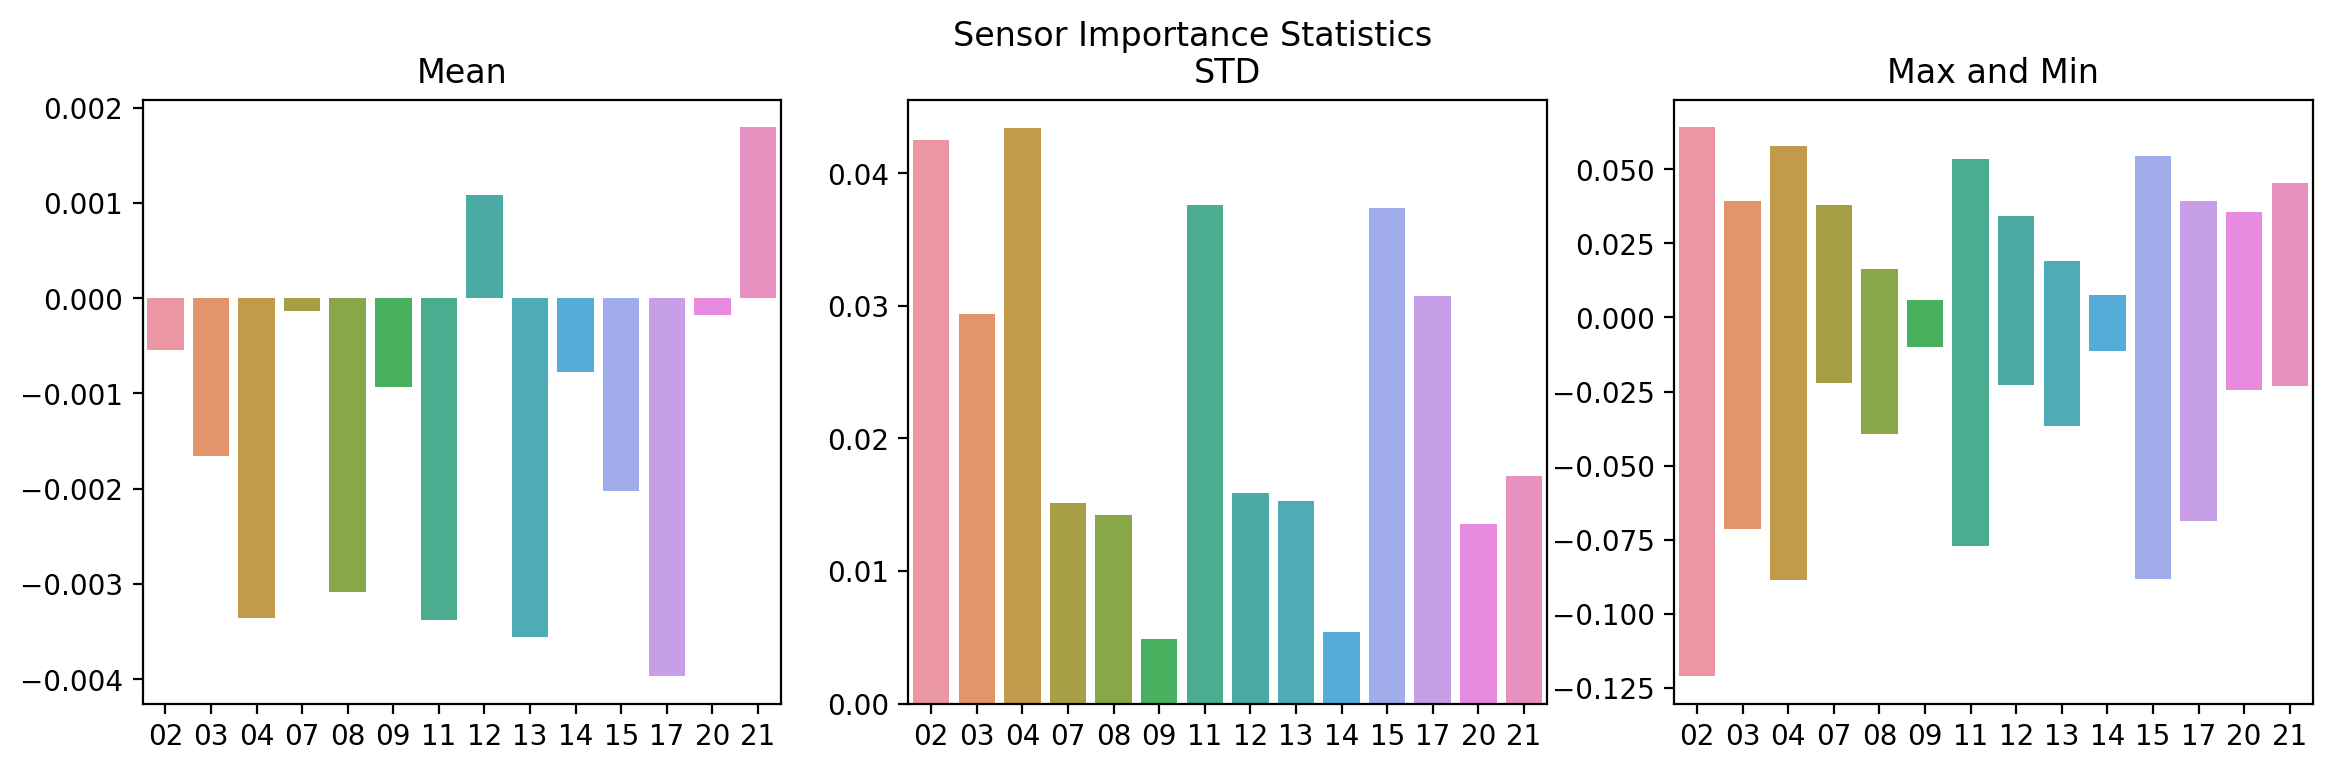

interactive(children=(IntSlider(value=1, description='sens_i', max=14, min=1), Output()), _dom_classes=('widge…

In [45]:
to_vis = [i[2:] for i in sensors]
fig, axs = plt.subplots(1, 3, figsize=(14, 4), dpi=200)
sns.barplot(to_vis,sensors_mean,ax=axs[0])
axs[0].set_title('Mean')
sns.barplot(to_vis,sensors_std,ax=axs[1])
axs[1].set_title('STD')
sns.barplot(to_vis,sensors_max,ax=axs[2])
sns.barplot(to_vis,sensors_min,ax=axs[2])
axs[2].set_title('Max and Min')
fig.suptitle('Sensor Importance Statistics')
plt.show()

def plot_sensor(sens_i=1):
    plt.figure(figsize=(14, 4), dpi=200, facecolor='w', edgecolor='k')
    plt.subplot(131)
    sns.lineplot(np.array(sensors_all['s_02'])[:,0],np.array(sensors_all[sensors[sens_i-1]])[:,1])
    plt.hlines(y=np.array(sensors_all[sensors[sens_i-1]])[:,1].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " influence"))
    plt.subplot(132)
    sns.lineplot(np.array(sensors_all['s_02'])[:,0],np.array(sensors_all[sensors[sens_i-1]])[:,2],color='g')
    plt.hlines(y=np.array(sensors_all[sensors[sens_i-1]])[:,2].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " value"))
    plt.subplot(133)
    sns.lineplot(np.array(sensors_all['s_02'])[:,0],np.array(sensors_all[sensors[sens_i-1]])[:,3],color='r')
    plt.hlines(y=np.array(sensors_all[sensors[sens_i-1]])[:,3].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " influence * value"))
    plt.show()
inter=interactive(plot_sensor 
   , sens_i=(1,14))
display(inter)

Let's modify the measurements from the s_11 sensor (number 7), which is is influencing negatively the RUL:

In [62]:
temp_instance = LSTM_x_train[113].copy()
sens = 12-1
for i in range(30,50):
    if weights.reshape(50,14)[i:i+1,sens:sens+1][0] < 0:
        temp_instance[i:i+1,sens:sens+1][0]=temp_instance[i:i+1,sens:sens+1][0]-0.15

Now let's test the modified instance

In [63]:
weights, real_prediction, local_prediction = lionet.explain_instance(temp_instance,1000,transparent_model)

In [64]:
"Real prediction: " + str(real_prediction)[:7] + ", Local prediction: " + str(local_prediction)[:7]

'Real prediction: 0.09577, Local prediction: 0.09578'

In [65]:
target_scaler.inverse_transform(np.array([[real_prediction],[local_prediction]]))

array([[29.8820141 ],
       [29.88422593]])

We managed to increase the RUL, a little. (Try and modify s_07 as well with the 12th sensor). How much does the RUL increased?

In [60]:
sensors_all = {}
count = 0
for j in range(50):
    count2 = 0
    for i in sensors:
        sensors_all.setdefault(i,[]).append([j, weights[count+count2], temp_instance[j][count2],
                                             weights[count+count2]*temp_instance[j][count2]])
        count2 = count2 + 1
    count = count + 14
sensors_std = []
sensors_mean = []
sensors_max = []
sensors_min = []
for i in sensors_all:
    naa = np.array(sensors_all[i])[:,3]
    sensors_std.append(naa.std())
    sensors_mean.append(naa.mean())
    sensors_max.append(naa.max())
    sensors_min.append(naa.min())
    #print(i, naa.mean(), naa.std(), naa.max(), naa.min())
statistics = pd.DataFrame({"Sensor": list(sensors), "Mean": list(sensors_mean), "STD": list(sensors_std), 
                           "Max": list(sensors_max), "Min": list(sensors_min), 
                           "Max-Min": np.array(sensors_max) + np.array(sensors_min)})

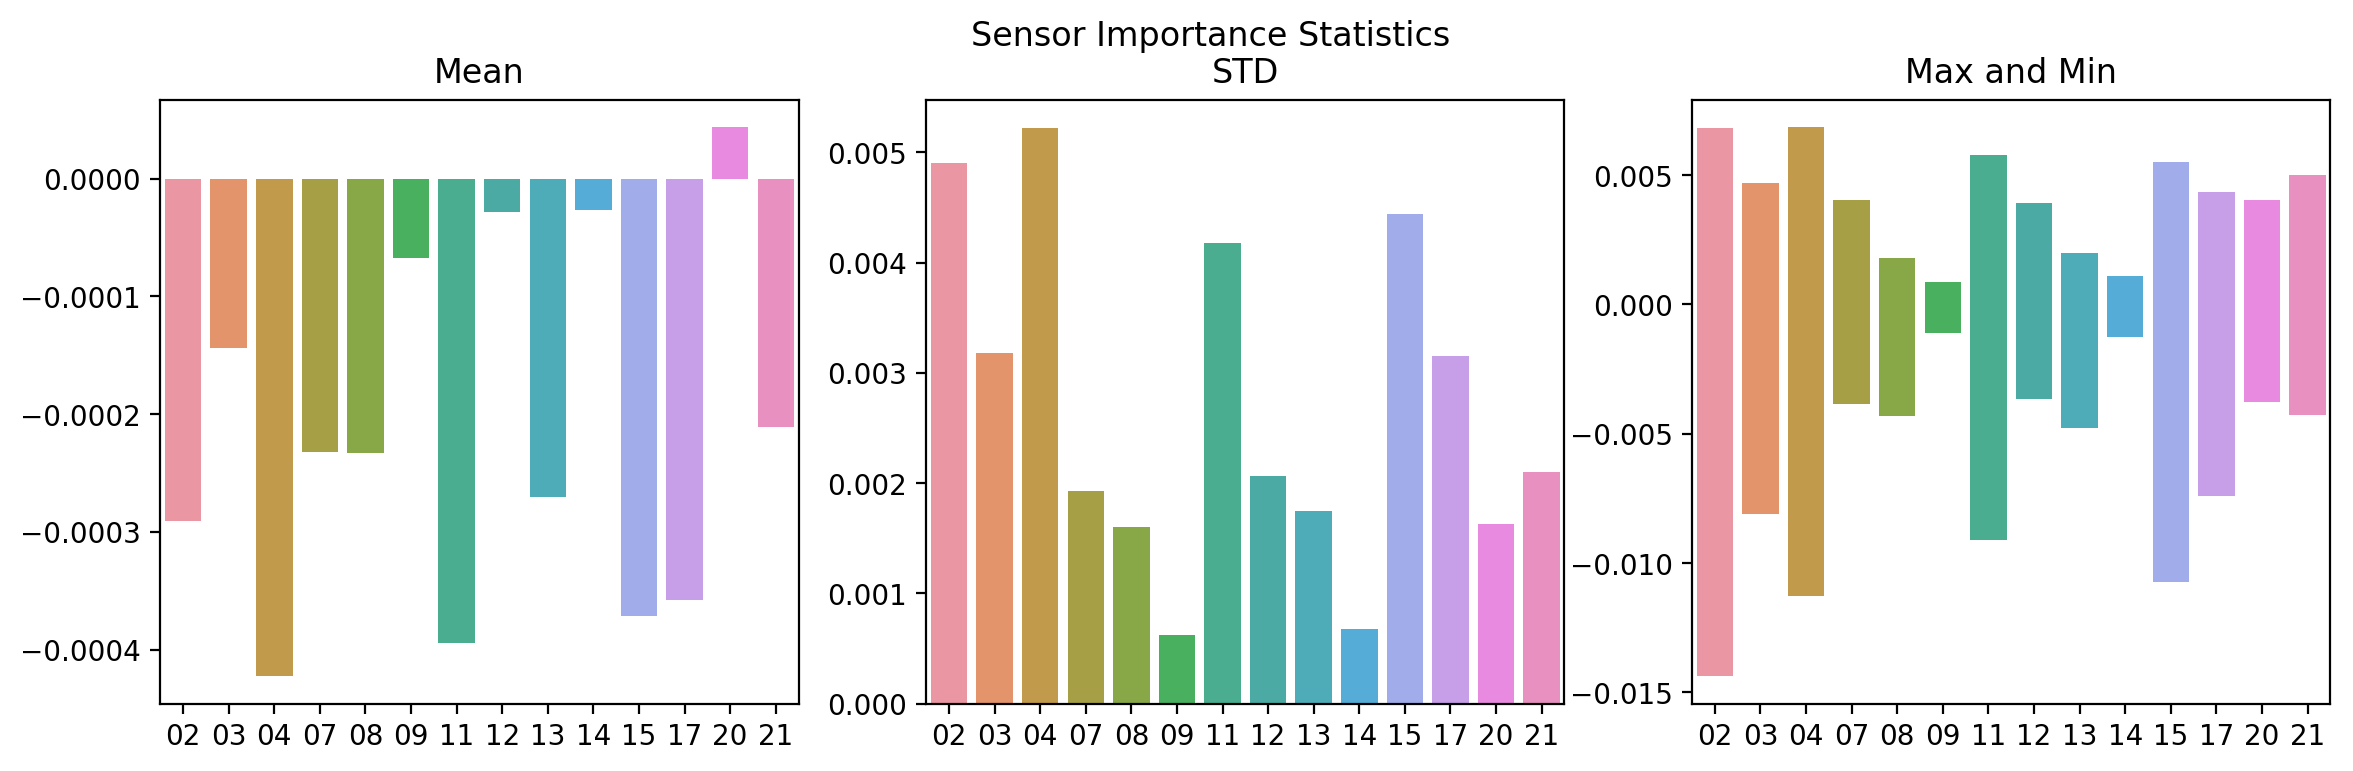

interactive(children=(IntSlider(value=1, description='sens_i', max=14, min=1), Output()), _dom_classes=('widge…

In [61]:
to_vis = [i[2:] for i in sensors]
fig, axs = plt.subplots(1, 3, figsize=(14, 4), dpi=200)
sns.barplot(to_vis,sensors_mean,ax=axs[0])
axs[0].set_title('Mean')
sns.barplot(to_vis,sensors_std,ax=axs[1])
axs[1].set_title('STD')
sns.barplot(to_vis,sensors_max,ax=axs[2])
sns.barplot(to_vis,sensors_min,ax=axs[2])
axs[2].set_title('Max and Min')
fig.suptitle('Sensor Importance Statistics')
plt.show()

def plot_sensor(sens_i=1):
    plt.figure(figsize=(14, 4), dpi=200, facecolor='w', edgecolor='k')
    plt.subplot(131)
    sns.lineplot(np.array(sensors_all['s_02'])[:,0],np.array(sensors_all[sensors[sens_i-1]])[:,1])
    plt.hlines(y=np.array(sensors_all[sensors[sens_i-1]])[:,1].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " influence"))
    plt.subplot(132)
    sns.lineplot(np.array(sensors_all['s_02'])[:,0],np.array(sensors_all[sensors[sens_i-1]])[:,2],color='g')
    plt.hlines(y=np.array(sensors_all[sensors[sens_i-1]])[:,2].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " value"))
    plt.subplot(133)
    sns.lineplot(np.array(sensors_all['s_02'])[:,0],np.array(sensors_all[sensors[sens_i-1]])[:,3],color='r')
    plt.hlines(y=np.array(sensors_all[sensors[sens_i-1]])[:,3].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " influence * value"))
    plt.show()
inter=interactive(plot_sensor 
   , sens_i=(1,14))
display(inter)

Try for another instance, and play with the plots :) Thanks for using LioNets.

For any question contact us at GitHub repo: https://github.com/intelligence-csd-auth-gr/LionLearn.git

or at our lab's website: https://intelligence.csd.auth.gr